# IA704 - Linear Classification Lab
## Edouard Ducloy

# Installation

In [1]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


Download repository with helper_cuda.h:

In [2]:
!git clone https://github.com/NVIDIA/cuda-samples.git

Cloning into 'cuda-samples'...
remote: Enumerating objects: 18274, done.
remote: Counting objects: 100% (3689/3689), done.
remote: Compressing objects: 100% (576/576), done.
remote: Total 18274 (delta 3346), reused 3150 (delta 3113), pack-reused 14585
Receiving objects: 100% (18274/18274), 133.19 MiB | 12.70 MiB/s, done.
Resolving deltas: 100% (16006/16006), done.
Updating files: 100% (3998/3998), done.


Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307

# Provided Code

## CUDA Utilities

In [3]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major,
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))

//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Writing cuda_stuff.cuh


In [4]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Writing cuda_stuff.cu


## fmatrix Matrix Tools

In [5]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

////////////////////////////////////////
// basic data structure and access macro
////////////////////////////////////////
typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/** Access element (i,j) of matrix M
 *
 *  Usage example:
 *  For computing A = B^T + C), loop over i and j with:
 *    getfm(A,i,j) = getfm(B,j,i) + getfm(C,i,j);
 **/
#define getfm(M,i,j) (M.data[IDX2C(i,j,M.rows)])

////////////////////////////////////////
// utility functions
////////////////////////////////////////
/** Returns the number of elements in the matrix.
 *
 *  Useful for computing, e.g., the size
 *  of a 1D-vector that contains the same numbers.
 */
 __host__
 __device__
int fmatrix_elements(fmatrix mat);

/** Returns the memory occupied by the matrix elements in bytes
 *  (not including the variables in the struct mat).
 *
 *  Useful for allocating memory for the data.
 */
 __host__
 __device__
int fmatrix_size(fmatrix mat);

/** Assert that the matrix is coherent: all fields nonzero. */
 __host__
 __device__
void fmatrix_assert(fmatrix mat);

////////////////////////////////////////
// Create, copy, destroy
////////////////////////////////////////
/** Allocate memory on host */
fmatrix fmatrix_create_on_host(int rows, int cols);

/** Allocate memory on device */
fmatrix fmatrix_create_on_device(int rows, int cols);

/** Create a matrix representing columns [a,b) of M.
 *  Note that the new matrix uses a pointer to the
 *  data of M. The data is not copied to a new location.
 *  If M is destroyed, this matrix is useless.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Copy data from matrix on device to host
 *  (no memory allocation). */
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);

/** Copy data from matrix on host to device
 *  (no memory allocation). */
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);

/** Copy matrix from device to host, allocating new memory. */
fmatrix fmatrix_copy_to_host(fmatrix mat_device);

/** Copy matrix from host to device, allocating new memory. */
fmatrix fmatrix_copy_to_device(fmatrix mat_host);

/** Free data memory on host.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_host(fmatrix* mat);

/** Free data memory on device.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_device(fmatrix* mat);

////////////////////////////////////////
// Input and Output
////////////////////////////////////////

/** Print the first nb rows of the matrix mat
 *  on the host.
 *  If nb<0, print all rows.
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device.
 *  If nb<0, print all rows.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

/** Print a matrix to a csv file.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_to_csv(const char* filename, fmatrix mat);

/** Read a matrix from a csv file.
 *
 *  This version creates the matrix on the host first.
 */
fmatrix fmatrix_device_from_csv(const char* filename);

////////////////////////////////////////
// Useful
////////////////////////////////////////

/** Create a matrix with random values between -1 and 1
 *  on the device */
fmatrix fmatrix_create_random_on_device(int rows, int cols);

#endif


Writing fmatrix.cuh


In [6]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <curand.h>
#include <curand_kernel.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

// for reading CSV files, we use some C++
#include <iostream>
#include <iomanip>
#include <fstream>
#include <string>

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
//    fmatrix_assert(mat);
     return fmatrix_elements(mat) * sizeof(float);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat));
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk(
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat))
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_device.data, mat_host.data,
                   fmatrix_size(mat_host),
                   cudaMemcpyHostToDevice
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,
                   fmatrix_size(mat_device),
                   cudaMemcpyDeviceToHost
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

/** We could do it like this, but it would not set our pointer M.data to 0.
... fmatrix_free_on_host(M)
void fmatrix_free_on_host(fmatrix mat) {
    fmatrix_assert(mat);
  free(mat.data);
  mat.data = 0;
  mat.cols = 0;
  mat.rows = 0;
}
*/

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);
    fmatrix A = {
        .data = &getfm(M,0,a),
        .cols = b-a,
        .rows = M.rows
    };
    fmatrix_assert(A);
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}

void fmatrix_device_to_csv(const char* filename, fmatrix mat) {
  // Open file
  FILE* fp = fopen(filename, "w");
  // allocate copy
  fmatrix tmp = fmatrix_copy_to_host(mat);
  for (int i = 0 ; i < tmp.rows; i++){
    for (int j = 0 ; j<tmp.cols; j++){
      // Note: %.15g gives 15 significant digits (full double precision)
      fprintf(fp,"%.15g", getfm(tmp,i,j));
      if (j+1<tmp.cols) {
        fprintf(fp,",");
      }
    }
    fprintf(fp,"\n");
  }
  fmatrix_free_on_host(&tmp);
  // Close file
  fclose(fp);
}

__global__
void fmatrix_create_random_on_device_kernel(fmatrix M) {
    // choose a seed (here: the same each launch)
    unsigned long seed = 0;
    int sequence = 0;
    // first, initialize the random numbers
    curandState state;
    curand_init(seed, sequence, 0, &state);
    for (int i = 0; i < fmatrix_elements(M); ++i) {
        // curand_uniform creates numbers between 0 and 1
        M.data[i] = (curand_uniform(&state)-0.5)*2.0;
    }
}

fmatrix fmatrix_create_random_on_device(int rows, int cols) {
    // Create an uninitialized matrix on the device
    fmatrix M = fmatrix_create_on_device(rows,cols);
    // Call a kernel with a single thread to fill the values
    fmatrix_create_random_on_device_kernel<<<1,1>>>(M);

    return M;
}

/* Count the number of rows and columns in a csv files (without headers) */
void count_elements_in_csv(const char* filename, int* rows, int* cols) {
  // Note: for the sake of convenience, we use some C++ functions here
  using namespace std;

  *rows = 0;
  *cols = 0;
  string row_as_string;
  string value;
  ifstream infile;
  infile.open(filename, ifstream::in);
	if (infile.is_open())
  {
    while (getline(infile, row_as_string, '\n')) {
				istringstream line_stream(row_as_string);
        int tempcols = 0;
        while (getline(line_stream, value, ',')) {
          ++tempcols;
        }
        if (tempcols > *cols) {
           *cols = tempcols;
        }
        ++(*rows);
			}
		infile.close();
	}
	else cout << "Cannot open file." << endl;
}

/** Read the data from a csv file into an fmatrix on the host.
 *  Careful: We assume that the matrix has the right dimensions!
 *  Use count_elements_in_csv(...) to get the dimensions if
 *  unknown.
 */
void fmatrix_fill_from_csv(fmatrix h_M,const char* filename) {
  // Note: for the sake of convenience, we use some C++ functions here
  using namespace std;
  string row_as_string;
  string value;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row = 0;
	if (infile.is_open())
  {
    while (getline(infile, row_as_string, '\n')) {
				istringstream line_stream(row_as_string);
        int col = 0;
        while (getline(line_stream, value, ',')) {
					getfm(h_M,row,col) = strtod(value.c_str(), NULL);
          ++col;
				}
        ++row;
			}
		infile.close();
	}
	else cout << "Cannot open file." << endl;
}

fmatrix fmatrix_device_from_csv(const char* filename) {
  // first read the file to count the number of elements
  int rows = 0;
  int cols = 0;
  count_elements_in_csv(filename,&rows,&cols);

  // allocate the matrix on the host
  fmatrix h_M = fmatrix_create_on_host(rows,cols);

  // read the data into the host matrix
  fmatrix_fill_from_csv(h_M,filename);

  // copy the matrix to the device
  fmatrix M = fmatrix_copy_to_device(h_M);

  // destroy the host matrix
  fmatrix_free_on_host(&h_M);

  return M;
}




Writing fmatrix.cu


## Data I/O

In [7]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Writing read_csv.cuh


In [8]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL);
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Writing read_csv.cu


In [9]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Writing preprocess_data.cuh


In [10]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major,
   ld = number of rows
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;
      }
		}

    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Writing preprocess_data.cu


# Code That You Write

## Classifier Math

In [11]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P,fmatrix Z);

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C);

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C);

/* Compute A = B-C */
void fmatrix_sub(fmatrix A, fmatrix B, fmatrix C);

/* Compute A_T = A^T */
void transpose(fmatrix A_T, fmatrix A);

/* Compute W = W-learning_rate*G */
void fmatrix_update_weights(fmatrix W, fmatrix G, float learning_rate);

/* Extract mus and sigmas from X columns */
void extract_mean_and_stddev(fmatrix X, fmatrix means, fmatrix sigmas);

/* Standardize X */
void standardize_matrix(fmatrix X, fmatrix means, fmatrix sigmas);

#endif

Writing classifier_math.cuh


In [12]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#include <cfloat>
#define THREADS_PER_BLOCK 1024

/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}

//// Softmax

__global__
void softmax_kernel_device(fmatrix P, fmatrix Z) {
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (col < P.cols) {
        float maxVal = getfm(Z, 0, col);
        float sum = 0.0;

        // Find the max value for numerical stability
        for (int row = 0; row < P.rows; ++row) {
            maxVal = max(maxVal, getfm(Z, row, col));
        }

        // Compute the exponential of the difference, sum for normalization
        for (int row = 0; row < P.rows; ++row) {
            float val = getfm(Z, row, col);
            float expVal = expf(val - maxVal);
            sum += expVal;
            getfm(P, row, col) = expVal;
        }

        // Normalize
        for (int row = 0; row < P.rows; ++row) {
            getfm(P, row, col) /= sum;
        }
    }
}

void softmax_col(fmatrix P,fmatrix Z) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);

    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the softmax here ...
    ///////////////////////////////////

    int threadsPerBlock = fmatrix_elements(Z);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    softmax_kernel_device<<<blocksPerGrid, threadsPerBlock>>>(P, Z);

    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}

//// Multiplication de matrice

__global__
void fmatrix_multiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.cols; ++k) {
          getfm(A,i,j) += f*getfm(B,i,k)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.rows);
    assert(A.cols == C.cols);
    assert(B.cols == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_multiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Multiplication de matrice avec transposé


__global__
void fmatrix_tmultiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.rows; ++k) {
          getfm(A,i,j) += f*getfm(B,k,i)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.cols);
    assert(A.cols == C.cols);
    assert(B.rows == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_tmultiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Soustraction de matrice

__global__
void matrix_sub_kernel(fmatrix A, fmatrix B, fmatrix C) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = getfm(B,i,j)-getfm(C,i,j);
    }
}

/* Compute A = B-C */
void fmatrix_sub(fmatrix A, fmatrix B, fmatrix C) {
    assert(A.rows == B.rows);
    assert(A.rows == C.rows);
    assert(A.cols == B.cols);
    assert(A.cols == C.cols);

    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    matrix_sub_kernel<<<blocksPerGrid, threadsPerBlock>>>(A,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Transposée de matrice

__global__
void transpose_kernel(fmatrix A_T, fmatrix A) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A_T,j,i) = getfm(A,i,j);
    }
}

/* Compute A_T = A^T */
void transpose(fmatrix A_T, fmatrix A) {
    assert(A_T.rows == A.cols);
    assert(A_T.cols == A.rows);

    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    transpose_kernel<<<blocksPerGrid, threadsPerBlock>>>(A_T,A);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Modification des poids

__global__
void update_weights_kernel(fmatrix W, fmatrix G, float learning_rate) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / W.rows;
    int i = idx % W.rows;
    if (i < W.rows && j < W.cols ){
        getfm(W,i,j) -= learning_rate*getfm(G,i,j);
    }
}

/* Compute W = W-learning_rate*G */
void fmatrix_update_weights(fmatrix W, fmatrix G, float learning_rate) {
    assert(W.rows == G.rows);
    assert(W.cols == G.cols);

    int threadsPerBlock = fmatrix_elements(W);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    update_weights_kernel<<<blocksPerGrid, threadsPerBlock>>>(W,G,learning_rate);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Extraction de mu et sigma

__global__
void extract_mean_and_stddev_kernel(fmatrix X, fmatrix means, fmatrix sigmas) {
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (col < X.cols) {
        float sum = 0.0;
        float sum_squares = 0.0;

        // Calculer la somme et la somme des carrés des éléments dans la colonne
        for (int row = 0; row < X.rows; ++row) {
            float val = getfm(X, row, col);
            sum += val;
            sum_squares += val * val;
        }

        // Calculer la moyenne
        float mean = sum / X.rows;
        getfm(means, 0, col) = mean;

        // Calculer l'écart-type (sigma)
        float variance = sum_squares / X.rows - mean * mean;
        float sigma = sqrtf(variance);
        getfm(sigmas, 0, col) = sigma;
    }
}

/* Extract mus and sigmas from X columns */
void extract_mean_and_stddev(fmatrix X, fmatrix means, fmatrix sigmas) {
    assert(means.cols == X.cols);
    assert(sigmas.cols == X.cols);
    assert(means.rows == 1);
    assert(sigmas.rows == 1);

    int threadsPerBlock = X.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock - 1) / THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }

    extract_mean_and_stddev_kernel<<<blocksPerGrid, threadsPerBlock>>>(X, means, sigmas);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Standardisation de matrice

__global__
void standardize_matrix_kernel(fmatrix X, fmatrix means, fmatrix sigmas) {
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (col > 0 && col < X.cols) {
        // Récupérer la moyenne et l'écart-type de la colonne
        float mean = getfm(means, 0, col);
        float sigma = getfm(sigmas, 0, col);

        // Normaliser chaque élément de la colonne
        for (int row = 0; row < X.rows; ++row) {
            float val = getfm(X, row, col);
            getfm(X, row, col) = (val - mean) / sigma;
        }
    }
}

/* Standardize X */
void standardize_matrix(fmatrix X, fmatrix means, fmatrix sigmas) {
    assert(means.cols == X.cols);
    assert(sigmas.cols == X.cols);
    assert(means.rows == 1);
    assert(sigmas.rows == 1);

    int threadsPerBlock = X.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock - 1) / THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }

    standardize_matrix_kernel<<<blocksPerGrid, threadsPerBlock>>>(X, means, sigmas);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}




Writing classifier_math.cu


## Evaluating Accuracy


In [13]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(j,k)*log(P(j,k))
 */
float evaluate_logloss(fmatrix d_P, fmatrix d_Y);


Writing evaluate_accuracy.cuh


In [14]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>

#define THREADS_PER_BLOCK 1024

__global__
void evaluate_accuracy_kernel(fmatrix d_Y,fmatrix d_Z,int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
        if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5) {
          atomicAdd(count,1);
      }
    }
}

float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);
    //printf("d_Y.cols: %d, d_Y.rows: %d, d_Z.cols: %d, d_Z.rows: %d\n",d_Y.cols,d_Y.rows,d_Z.cols,d_Z.rows);

  //////////////////////////////////////////
  // 1. compute Z = W^T X
  // --> each column of Z corresponds to one input
  //////////////////////////////////////////

  /*********************************
  / TO BE COMPLETED
  / ... compute Z = W^T X here ...
  **********************************/

  fmatrix_tmult(d_Z, 1.0, d_W, d_X);

  //////////////////////////////////////////
  // 2. For each column z of Z,
  // find argmax_k z_k
  //////////////////////////////////////////

  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk(
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y,d_Z,d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}

__global__
void evaluate_logloss_kernel(fmatrix d_P, fmatrix d_Y, float* d_loss) {
    int index = threadIdx.x + blockIdx.x * blockDim.x;
    if (index < d_P.rows*d_P.cols) {
        int row = index / d_P.cols;
        int col = index % d_P.cols;
        float p = getfm(d_P, row, col);
        //printf("\n%.5f\n", p);
        float y = getfm(d_Y, row, col);
        //printf("\n%.5f\n", y);
        float loss = 0.0;
        if (p > 0 && p < 1) {
           loss = -y * logf(p) - (1.0 - y) * logf(1.0 - p);
        }
        atomicAdd(d_loss, loss);
    }
}

float evaluate_logloss(fmatrix d_P, fmatrix d_Y) {
    assert(d_Y.cols == d_P.cols);
    assert(d_Y.rows == d_P.rows);

    float J = 0.0;
    float* d_loss;
    cudaMalloc(&d_loss, sizeof(float));
    cudaMemset(d_loss, 0, sizeof(float)); // Initialize accumulator

    int threadsPerBlock = fmatrix_elements(d_P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock - 1) / THREADS_PER_BLOCK + 1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_logloss_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_P, d_Y, d_loss);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

    // Copy the result back to host
    cudaMemcpy(&J, d_loss, sizeof(float), cudaMemcpyDeviceToHost);
    J /= fmatrix_elements(d_P); // Normalize the log loss by the number of elements
    cudaFree(d_loss); // Clean up

    return J;
}


Writing evaluate_accuracy.cu


## Linear Classifier - Basic SGD

In [15]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{

    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; //12000; // points for training (Google: 12000)
    size_t N_test = 5000; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 100;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // defeault: N;
    float learning_rate = 1e-4; // default: 1e-7

    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);

    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);

    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    fmatrix d_Q = fmatrix_create_on_device(M, batch_size);
    fmatrix d_Q_T = fmatrix_create_on_device(batch_size, M);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);

     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    //printf("X:\n");fmatrix_device_print(d_X);

    // Standarisation de X et Xtest
    fmatrix d_X_T = fmatrix_create_on_device(N, D);
    fmatrix d_Xtest_T = fmatrix_create_on_device(N_test, D);
    fmatrix means = fmatrix_create_on_device(1, D);
    fmatrix sigmas = fmatrix_create_on_device(1, D);

    transpose(d_X_T, d_X);
    transpose(d_Xtest_T, d_Xtest);
    extract_mean_and_stddev(d_X_T, means, sigmas);
    //printf("mu:\n");fmatrix_device_print(means);
    //printf("sigma:\n");fmatrix_device_print(sigmas);
    standardize_matrix(d_X_T, means, sigmas);
    standardize_matrix(d_Xtest_T, means, sigmas);
    transpose(d_X, d_X_T);
    transpose(d_Xtest, d_Xtest_T);

    //printf("X:\n");fmatrix_device_print(d_X);

    // int batch_pointer = 0;
    for (int i = 0; i < nb_iter; ++i ) {

      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////

      fmatrix_tmult(d_Z,1.0,d_W,d_X);

      ///////////////////////////////////
      // TO BE COMPLETED
      ///////////////////////////////////

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in P
      softmax_col(d_P, d_Z);

      // evaluate logloss (for reporting only)
      J = evaluate_logloss(d_P, d_Y);

      // Q:=P-Y
      fmatrix_sub(d_Q, d_P, d_Y);
      //fmatrix_device_print(d_Q);

      // compute gradient G = XQ^T
      transpose(d_Q_T, d_Q);
      //fmatrix_device_print(d_Q_T);
      fmatrix_mult(d_G, 1.0, d_X, d_Q_T);
      //fmatrix_device_print(d_G);

      // ... possibly work with G here ...
      // update weights W = W - learning_rate*G
      fmatrix_update_weights(d_W, d_G, learning_rate);

      ///////////////////////////////////
      // TO BE COMPLETED
      ///////////////////////////////////

      //printf("W:\n");fmatrix_device_print(d_W);
      //printf("Xtest:\n");fmatrix_device_print(d_Xtest);
      //printf("Ytest:\n");fmatrix_device_print(d_Ytest);

      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
    fmatrix_free_on_device(&d_X_T);
    fmatrix_free_on_device(&d_Xtest_T);
    fmatrix_free_on_device(&means);
    fmatrix_free_on_device(&sigmas);
    fmatrix_free_on_device(&d_Q);
    fmatrix_free_on_device(&d_Q_T);
    fmatrix_free_on_device(&d_G);

    // Close log file
    fclose(fp);
}

Writing linear_classification.cu


### Compiling

In [16]:
!nvcc -o linclass_basic.out -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

### Experiments

In [17]:
%%time
!./linclass_basic.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.660200
iter: 0, logloss: 0.880323, accuracy: 0.688600
iter: 1, logloss: 0.499257, accuracy: 0.718400
iter: 2, logloss: 0.420793, accuracy: 0.723600
iter: 3, logloss: 0.384562, accuracy: 0.733

Let's plot the logloss and accuracy.

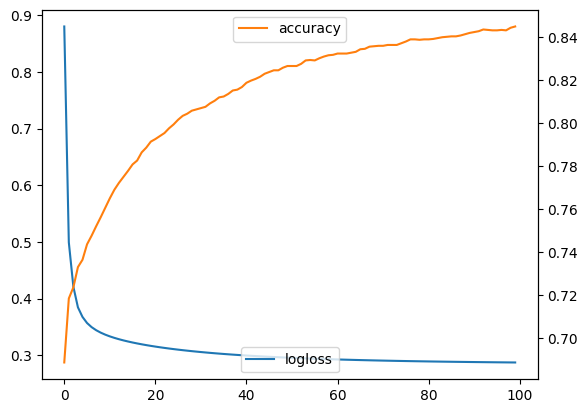

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
plt.legend(loc='lower center')
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.legend(loc='upper center')
plt.show()

## Linear Classifier - SGD with Mini-Batches

In [19]:
%%writefile linear_classification_mb.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{

    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; //12000; // points for training (Google: 12000)
    size_t N_test = 5000; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log_mb.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 25;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = 300;         // defeault: N;
    float learning_rate = 1e-3; // default: 1e-7

    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);

    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);

    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    fmatrix d_Q = fmatrix_create_on_device(M, batch_size);
    fmatrix d_Q_T = fmatrix_create_on_device(batch_size, M);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);

     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    //printf("X:\n");fmatrix_device_print(d_X);

    // Standarisation de X et Xtest
    fmatrix d_X_T = fmatrix_create_on_device(N, D);
    fmatrix d_Xtest_T = fmatrix_create_on_device(N_test, D);
    fmatrix means = fmatrix_create_on_device(1, D);
    fmatrix sigmas = fmatrix_create_on_device(1, D);

    transpose(d_X_T, d_X);
    transpose(d_Xtest_T, d_Xtest);
    extract_mean_and_stddev(d_X_T, means, sigmas);
    //printf("mu:\n");fmatrix_device_print(means);
    //printf("sigma:\n");fmatrix_device_print(sigmas);
    standardize_matrix(d_X_T, means, sigmas);
    standardize_matrix(d_Xtest_T, means, sigmas);
    transpose(d_X, d_X_T);
    transpose(d_Xtest, d_Xtest_T);

    //printf("X:\n");fmatrix_device_print(d_X);

    // int batch_pointer = 0;
    for (int i = 0; i < nb_iter; ++i ) {
          for (int batch_pointer = 0; batch_pointer < N / batch_size; ++batch_pointer) {
              int startCol = batch_pointer * batch_size;
              int endCol = startCol + batch_size;

              fmatrix d_Xbatch = fmatrix_subcolumns(d_X, startCol, endCol);
              fmatrix d_Ybatch = fmatrix_subcolumns(d_Y, startCol, endCol);

              ////////////////////////////////
              // compute Z = W^T X
              // --> each column z of Z corresponds to one column x of X
              ////////////////////////////////

              fmatrix_tmult(d_Z,1.0,d_W,d_Xbatch);

              ///////////////////////////////////
              // TO BE COMPLETED
              ///////////////////////////////////

              ////////////////////////////////
              // For each column z of Z, compute activation p(z);
              // then update W
              ////////////////////////////////

              // compute softmax per column of Z and store in P
              softmax_col(d_P, d_Z);

              // evaluate logloss (for reporting only)
              J = evaluate_logloss(d_P, d_Ybatch);

              // Q:=P-Y
              fmatrix_sub(d_Q, d_P, d_Ybatch);

              // compute gradient G = XQ^T
              transpose(d_Q_T, d_Q);
              fmatrix_mult(d_G, 1.0, d_Xbatch, d_Q_T);

              // ... possibly work with G here ...
              // update weights W = W - learning_rate*G
              fmatrix_update_weights(d_W, d_G, learning_rate);

          }

          //printf("W:\n");fmatrix_device_print(d_W);

          ////////////////////////////////
          // For reporting, compute logloss and accuracy
          ////////////////////////////////
          if (i%(nb_iter/periods)==0) {
          float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
          printf("iter: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
          fprintf(fp, "%f,%f\n", J, accuracy);
          }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
    fmatrix_free_on_device(&d_X_T);
    fmatrix_free_on_device(&d_Xtest_T);
    fmatrix_free_on_device(&means);
    fmatrix_free_on_device(&sigmas);
    fmatrix_free_on_device(&d_Q);
    fmatrix_free_on_device(&d_Q_T);
    fmatrix_free_on_device(&d_G);

    // Close log file
    fclose(fp);
}

Writing linear_classification_mb.cu


### Compiling

In [20]:
!nvcc -o linclass_mb.out -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification_mb.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

### Experiments

In [21]:
%%time
!./linclass_mb.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.660200
iter: 0, logloss: 0.124869, accuracy: 0.727000
iter: 1, logloss: 0.107046, accuracy: 0.745800
iter: 2, logloss: 0.104375, accuracy: 0.761800
iter: 3, logloss: 0.101876, accuracy: 0.775

Let's plot the logloss and accuracy.

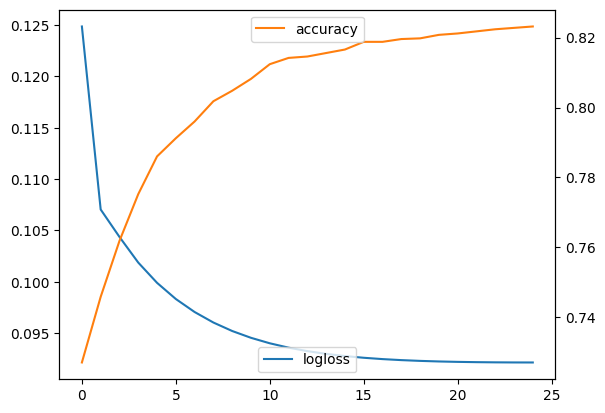

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log_mb.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
plt.legend(loc='lower center')
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.legend(loc='upper center')
plt.show()

# Results summary

Basic SGD
- final accuracy: 84.5%
- runtime: 0.35s
- 100 epochs
- learning rate: 1e-4

Mini-batch SGD
- final accuracy: 82.3%
- runtime: 0.20s
- batch size: 300
- 25 epochs
- learning rate: 1e-3
